In [1]:
# 1. My current implementation of the Differentiable Darmois construction does not have triangular Jacobian
# 2. That is because the MAF implementation employs flow.Reverse() layers, which change the order of the variables across successive layers
# 3. If I remove those, the network does not appear to learn any nonlinear transformation for the 1st component; it only applies an (almost?) linear transformation to the first variable
# 4. (Additionally, there appears to be some problem with the Jacobian... Somehow I don't manage to figure out  
#     how to evaluate it -- neither with nor without vmap -- on the Flow and get the correct dimensionality.)

# QUESTIONS: 1. Can I find a better autoregressive flow, more expressive than MAF? -> A: Try Neural Spline Flows.
#            2. Can I evaluate the goddamn Jacobian properly with it?

# Alternative path
# 5. Focuse on closed form implementation for now
# 6. Try again with Neural Spline Flows

In [2]:
# For the closed form implementation you might need the error function and/or its inverse, possibly in a differentiable form

In [3]:
from jax import numpy as np

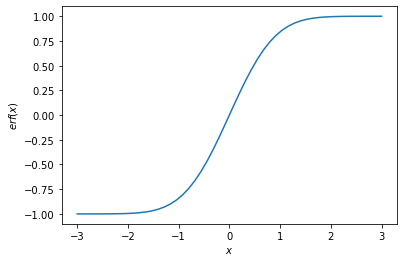

In [4]:
from scipy import special
import matplotlib.pyplot as plt
x = np.linspace(-3, 3)

plt.plot(x, special.erf(x))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

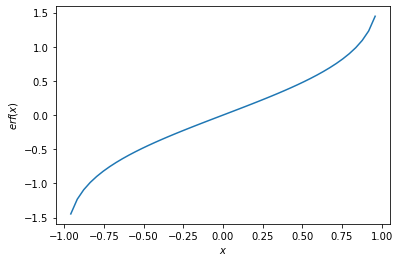

In [5]:
from jax.scipy import special
y = np.linspace(-1.0, 1.0)

plt.plot(y, special.erfinv(y))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

### 1. Generate data from a uniform distribution

In [6]:
# N:=Number of samples
N = 60000
# D:=Number of dimensions
D = 2

In [7]:
from jax import random
key = random.PRNGKey(0)

S = random.uniform(key, shape=(D, N), minval=0.0, maxval=1.0)

In [8]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

_, phi = cart2pol( S[0]-0.5, S[1]-0.5)

colors = phi

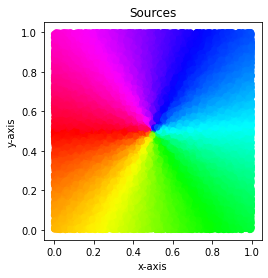

In [9]:
# Plot sources
plt.scatter(S[0], S[1], c=colors, s=30, alpha=0.75, cmap='hsv')
# plt.scatter(S[0], S[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2. Mixing (CDF + linear)

In [10]:
# mean=np.zeros(D*2)
# mean
# cov=np.eye(D*2)
# cov

In [11]:
A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(2*D)).reshape(2,2)
A = np.sqrt(np.abs(A))*np.sign(A)
A

DeviceArray([[ 1.3476223, -0.8688413],
             [ 0.583    , -0.7313245]], dtype=float32)

In [12]:
A.shape

(2, 2)

In [13]:
A_inv = np.linalg.inv(A)

In [14]:
# Turn them into normal R.V.
S_normal = special.erfinv(S*2.0-1.0)

# Check that they **are** normal!
Norm = random.multivariate_normal(key, mean=np.zeros(D), cov=np.eye(D), shape=[N]).T

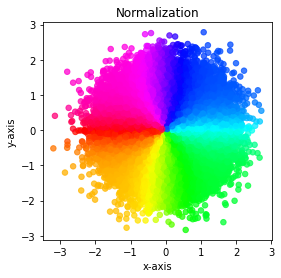

In [15]:
# Plot observations
plt.scatter(S_normal[0], S_normal[1], c=colors, s=30, alpha=0.75, cmap='hsv')
# plt.scatter(Norm[0], Norm[1], color='blue', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Normalization')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [16]:
Norm.shape

(2, 60000)

In [17]:
# Apply a linear mixing
X = A @ S_normal 
# X = A @ Norm

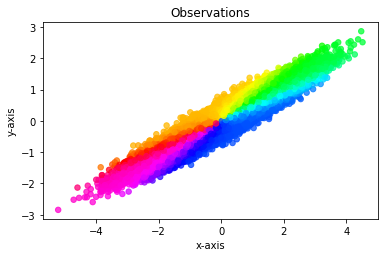

In [18]:
# Plot observations
plt.scatter(X[0], X[1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 3. Build Darmois

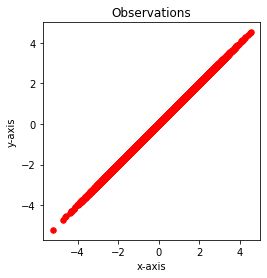

In [19]:
plt.scatter(X[0], A[0, 0]*S_normal[0]+A[0, 1]*S_normal[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

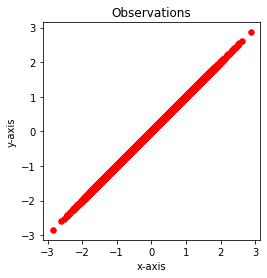

In [20]:
plt.scatter(X[1], A[1, 0]*S_normal[0]+A[1, 1]*S_normal[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [21]:
def darmois_linear_gaussian(A):
    sigma_0 = np.sqrt(A[0,0]**2 + A[0,1]**2) 
    sigma_1 = np.sqrt(A[1,0]**2 + A[1,1]**2) 
    rho_01 = (A[0,0]*A[1,0] + A[0,1]*A[1,1])/(sigma_0*sigma_1)
    c_1_given_0 = rho_01*sigma_1/sigma_0
    
    def darmois(x):
        y_0 = 0.5*(1.0 + special.erf(x[0]/(sigma_0*np.sqrt(2.0))))
        y_1 = 0.5*(1.0 + special.erf( (x[1] - c_1_given_0* x[0]) /np.sqrt( 2 * ( 1.0 - rho_01**2) * sigma_1**2 )))
        return np.vstack([y_0, y_1])

    def inv_darmois(y):
        s_0 = sigma_0*np.sqrt(2)*special.erfinv(2.0*y[0]-1.0)
        s_1 = np.sqrt( 2 * ( 1.0 - rho_01**2) * sigma_1**2 ) * special.erfinv(2.0*y[1]-1.0) + c_1_given_0 * s_0
        return np.vstack([s_0, s_1])    
    
    return darmois, inv_darmois

In [22]:
darmois, inv_darmois = darmois_linear_gaussian(A)

In [23]:
Y = darmois(X)

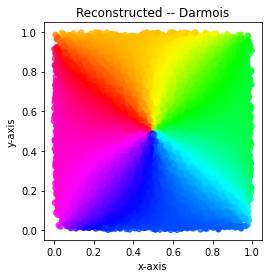

In [24]:
# Plot reconstructed -- Darmois
plt.scatter(Y[0], Y[1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reconstructed -- Darmois')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

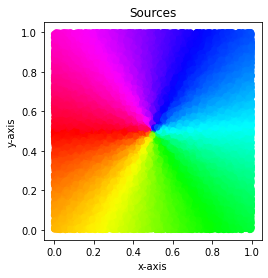

In [25]:
# Plot sources
plt.scatter(S[0], S[1], c=colors, s=30, alpha=0.75, cmap='hsv')
# plt.scatter(S[0], S[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Check that the inverse function does what it should

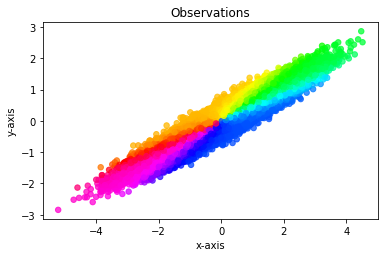

In [26]:
# Plot observations
plt.scatter(X[0], X[1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [27]:
X_ = inv_darmois(Y)

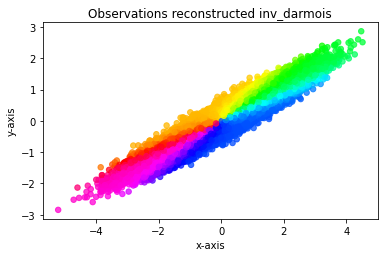

In [28]:
# Plot observations reconstructed inv_darmois
plt.scatter(X_[0], X_[1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations reconstructed inv_darmois')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# To do:
- ~Add colormap to visualize distorsion due to Darmois~
- ~Invert the function!~
- Compute its Jacobian/the various metrics

In [29]:
from jax import jacfwd, vmap

In [30]:
Jdarmois = jacfwd(darmois)

In [31]:
Jdarmois_batched = vmap(Jdarmois)

In [32]:
Jdarmois(Y[0]).shape

(2, 1, 60000)

In [33]:
Y.shape

(2, 60000)

### There is still some issue with the Jacobian computation...